In [1]:
# Import necessary libraries
import os  # For handling file and directory operations
import shutil  # For file copying and directory management
from sklearn.model_selection import train_test_split  # For splitting datasets into train, test, and validation sets
from pyspark.sql import SparkSession, Row  # For creating and managing Spark DataFrames
import plotly.express as px  # For creating visualizations such as pie charts and bar charts
from pymongo import MongoClient  # For connecting to MongoDB
import gridfs  # For managing large files in MongoDB
from PIL import Image  # For handling image processing
import matplotlib.pyplot as plt  # For plotting images and graphs
import io  # For handling byte streams (used with image processing)

# DATA STORAGE USING MONGODB

In [2]:
# Connecting to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["plant"]  # Database name
fs = gridfs.GridFS(db)  # Initialize GridFS for handling large files
print("MongoDB connection established.")

MongoDB connection established.


## SPARK SESSION

In [3]:
# Initializing Spark Session
spark = SparkSession.builder \
    .appName("PlantImageClassification") \
    .getOrCreate()
print("Spark Session initialized.")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/05 16:35:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/05 16:35:34 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/05 16:35:34 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/12/05 16:35:34 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/12/05 16:35:34 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


Spark Session initialized.


In [9]:
def split_dataset(dataset_path, output_path, test_size=0.2, val_size=0.1):
    """
    Splits a dataset into training, validation, and testing sets.

    Parameters:
    - dataset_path: Path to the root dataset folder.
    - output_path: Path to the folder where split data will be stored.
    - test_size: Proportion of the dataset to be used as the test set.
    - val_size: Proportion of the training data to be used as the validation set.
    """
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        if len(images) == 0:
            print(f"Skipping empty class folder: {class_name}")
            continue

        if len(images) < 3:
            print(f"Class '{class_name}' has only {len(images)} sample(s). Allocating all to training.")
            train_imgs, val_imgs, test_imgs = images, [], []
        else:
            # Split into train, test, and validation sets
            train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)
            train_imgs, val_imgs = train_test_split(train_imgs, test_size=val_size / (1 - test_size), random_state=42)

        # Create output directories
        for split, split_imgs in zip(["Training Data", "Testing Data", "Validation Data"], [train_imgs, test_imgs, val_imgs]):
            split_class_path = os.path.join(output_path, split, class_name)
            os.makedirs(split_class_path, exist_ok=True)
            for img in split_imgs:
                shutil.copy(os.path.join(class_path, img), os.path.join(split_class_path, img))
        
        print(f"Processed class: {class_name}")

# Example usage
DATASET_PATH = "archive"  
OUTPUT_PATH = "archive"  

# Split the dataset
split_dataset(DATASET_PATH, OUTPUT_PATH)


Class 'Validation Data' has only 1 sample(s). Allocating all to training.
Processed class: Validation Data
Processed class: Wheat__healthy
Processed class: Pepper_bell__healthy
Processed class: Cassava__healthy
Processed class: Peach__healthy
Processed class: Lemon__diseased
Processed class: Mango__diseased
Processed class: Corn__healthy
Processed class: Tomato__healthy
Processed class: Lemon__healthy
Processed class: Gauva__diseased
Processed class: Cassava__mosaic_disease
Processed class: Grape__healthy
Processed class: Apple__healthy
Processed class: Jamun__healthy
Processed class: Potato__healthy
Processed class: Chili__healthy
Class 'Testing Data' has only 1 sample(s). Allocating all to training.
Processed class: Testing Data
Class 'Training Data' has only 1 sample(s). Allocating all to training.
Processed class: Training Data
Processed class: Soybean__healthy
Processed class: Peach__bacterial_spot
Processed class: Sugarcane__healthy
Processed class: Jamun__diseased
Processed clas

In [10]:
# Visualizing Dataset Distribution
def visualize_class_distribution(base_path):
    # Get class names and calculate distributions
    classes = [
        d for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d))
    ]
    class_distributions = [
        len(os.listdir(os.path.join(base_path, class_name)))
        if os.path.exists(os.path.join(base_path, class_name)) else 0
        for class_name in classes
    ]

    # Visualize with pie chart and bar chart
    fig = px.pie(names=classes, values=class_distributions, title="Class Distribution", hole=0.4)
    fig.update_layout({'title': {'x': 0.48}})
    fig.show()

    fig = px.bar(x=classes, y=class_distributions, title="Class Distribution")
    fig.update_layout({'title': {'x': 0.48}})
    fig.show()

# Visualizing the Training dataset distribution
visualize_class_distribution(os.path.join(DATASET_PATH, "Training Data"))

In [11]:
# Creating Spark DataFrames
def create_spark_dataframe(data_type, base_path):
    split_path = os.path.join(base_path, f"{data_type} Data")
    if not os.path.exists(split_path):
        print(f"Warning: Folder '{split_path}' does not exist.")
        return None

    data = []
    classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
    for class_name in classes:
        class_path = os.path.join(split_path, class_name)
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]
        for img in images:
            data.append(Row(path=img, label=class_name))
    
    return spark.createDataFrame(data)


In [12]:
# Create Spark DataFrames for Training, Validation, and Testing
train_images_df = create_spark_dataframe("Training", DATASET_PATH)
validation_images_df = create_spark_dataframe("Validation", DATASET_PATH)
test_images_df = create_spark_dataframe("Testing", DATASET_PATH)

# Show DataFrame schemas
if train_images_df:
    train_images_df.printSchema()
if validation_images_df:
    validation_images_df.printSchema()
if test_images_df:
    test_images_df.printSchema()

# Upload to MongoDB GridFS
def upload_images_to_gridfs():
    for data_type in ["Training Data", "Validation Data", "Testing Data"]:
        split_path = os.path.join(DATASET_PATH, data_type)
        classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
        for class_name in classes:
            class_path = os.path.join(split_path, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    # Check for duplicate metadata
                    existing_entry = db.image_metadata.find_one({"filename": img_name, "class_name": class_name})
                    if existing_entry is None:
                        with open(img_path, "rb") as img_file:
                            # Save file to GridFS
                            file_id = fs.put(img_file, filename=img_name, class_name=class_name)
                            db.image_metadata.insert_one({"file_id": file_id, "filename": img_name, "class_name": class_name})
                            print(f"Uploaded: {img_name} in class {class_name}")
                    else:
                        print(f"Skipped (already exists): {img_name}")
                except Exception as e:
                    print(f"Error uploading {img_name} in class {class_name}: {e}")

upload_images_to_gridfs()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)

Uploaded: .DS_Store in class Validation Data
Skipped (already exists): Healthy902.jpg
Skipped (already exists): Healthy296.jpg
Skipped (already exists): Healthy269.jpg
Skipped (already exists): Healthy255.jpg
Skipped (already exists): Healthy1010.jpg
Skipped (already exists): Healthy1004.jpg
Skipped (already exists): loh(22).JPG
Skipped (already exists): Healthy309.jpg
Skipped (already exists): Healthy321.jpg
Skipped (already exists): Healthy447.jpg
Skipped (already exists): Healthy1170.jpg
Skipped (already exists): Healthy692.jpg
Skipped (already exists): Healthy679.jpg
Skipped (already exists): loh(75).JPG
Skipped (already exists): Healthy650.jpg
Skipped (already exists): Healthy644.jpg
Skipped (already exists): Healthy1367.jpg
Skipped (already exists

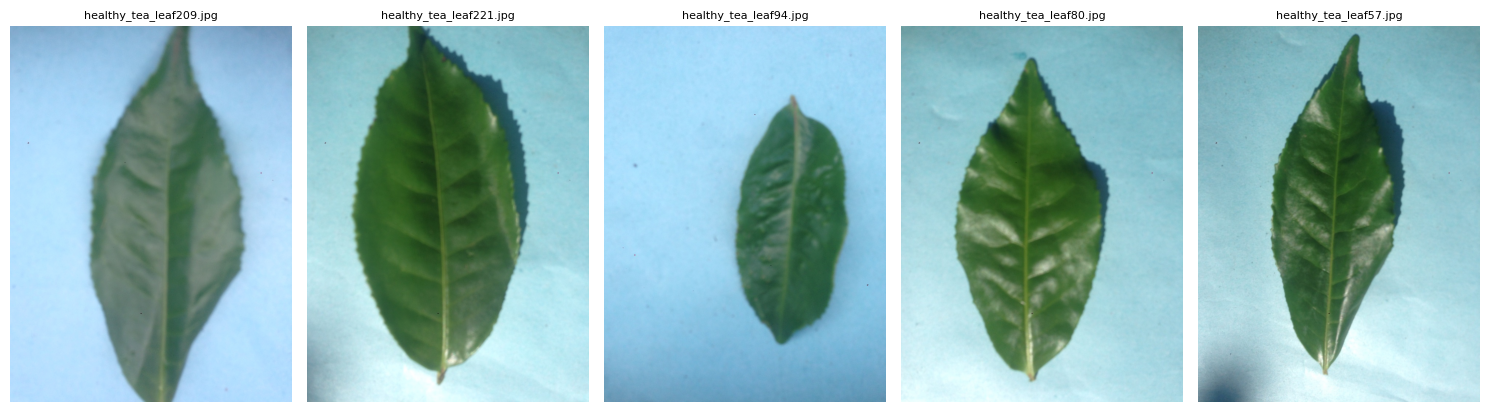

In [13]:
# Example: Fetch and Display Images
def fetch_images_by_class(class_name, max_images=5):
    files = list(db.image_metadata.find({"class_name": class_name}).limit(max_images))
    if not files:
        print(f"No images found for class '{class_name}'.")
        return
    
    fig, axes = plt.subplots(1, len(files), figsize=(15, 5))
    if len(files) == 1:
        axes = [axes]
    
    for ax, file in zip(axes, files):
        img_binary = fs.get(file["file_id"]).read()
        img = Image.open(io.BytesIO(img_binary))
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(file["filename"], fontsize=8)
    plt.tight_layout()
    plt.show()

# Example usage
fetch_images_by_class("Tea__healthy")

## Data Augmentation and Data Generators

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,            # Normalizes pixel values to [0, 1] range
    rotation_range=20,          # Randomly rotates images within 20 degrees
    width_shift_range=0.2,      # Randomly shifts the width of images by up to 20% of the total width
    height_shift_range=0.2,     # Randomly shifts the height of images by up to 20% of the total height
    shear_range=0.2,            # Applies random shearing transformations
    zoom_range=0.2,             # Randomly zooms into images by up to 20%
    horizontal_flip=True        # Randomly flips images horizontally
)

# Data generator for validation dataset (no augmentation, only rescaling)
val_datagen = ImageDataGenerator(
    rescale=1.0/255             # Normalizes pixel values to [0, 1] range
)

# Paths to the training and validation datasets
train_dir = "archive/Training Data"  # Path to the training dataset
val_dir = "archive/Validation Data"  # Path to the validation dataset

# Data generators for training dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,                  # Directory containing training images
    target_size=(150, 150),     # Resizes all images to 150x150 pixels
    batch_size=32,              # Number of images to yield per batch
    class_mode='categorical'    # Labels are one-hot encoded for multi-class classification
)

# Data generators for validation dataset
val_generator = val_datagen.flow_from_directory(
    val_dir,                    # Directory containing validation images
    target_size=(150, 150),     # Resizes all images to 150x150 pixels
    batch_size=32,              # Number of images to yield per batch
    class_mode='categorical'    # Labels are one-hot encoded for multi-class classification
)

Found 11979 images belonging to 36 classes.
Found 4849 images belonging to 36 classes.


## model development pipeline for image classification

Sequential:

1). A sequential model is a linear stack of layers where you can add one layer after another.
Used when layers flow in a single direction (no shared layers or multiple inputs/outputs).
Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)):

2). Adds a 2D convolutional layer with 32 filters, each of size 3x3.
Activation: ReLU (Rectified Linear Unit) is used to introduce non-linearity.
Input shape: (150, 150, 3) specifies the input image dimensions (150x150 pixels, 3 channels for RGB).
MaxPooling2D((2, 2)):

3). Down-samples the spatial dimensions of the feature maps by selecting the maximum value in a 2x2 window.
Reduces computation and helps avoid overfitting.
Conv2D(64, (3, 3), activation='relu'):

4). Adds another convolutional layer with 64 filters of size 3x3.
Used for deeper feature extraction from the image.
MaxPooling2D((2, 2)):

5). Reduces the spatial dimensions further after the second convolutional layer.
Flatten():

Flattens the 2D feature maps from the convolutional layers into a 1D vector for input into the fully connected layers.
Dense(128, activation='relu'):

6). Fully connected layer with 128 neurons.
Uses ReLU activation to introduce non-linearity and learn complex patterns.
Dense(len(train_generator.class_indices), activation='softmax'):

7). Output layer with neurons equal to the number of classes in your dataset.
Activation: Softmax is used for multi-class classification to output probabilities for each class.

In [15]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')  # Adjust output layer to the number of classes
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



375/375 ━━━━━━━━━━━━━━━━━━━━ 245s 646ms/step - accuracy: 0.4018 - loss: 2.3003 - val_accuracy: 0.7107 - val_loss: 0.9371
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 250s 656ms/step - accuracy: 0.6804 - loss: 0.9605 - val_accuracy: 0.7373 - val_loss: 0.8432
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 251s 662ms/step - accuracy: 0.7341 - loss: 0.7792 - val_accuracy: 0.7661 - val_loss: 0.7467
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 246s 646ms/step - accuracy: 0.7612 - loss: 0.6905 - val_accuracy: 0.7569 - val_loss: 0.7823
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 251s 663ms/step - accuracy: 0.7702 - loss: 0.6771 - val_accuracy: 0.8303 - val_loss: 0.5129
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 252s 666ms/step - accuracy: 0.7943 - loss: 0.6007 - val_accuracy: 0.8377 - val_loss: 0.5033
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 248s 653ms/step - accuracy: 0.8047 - loss: 0.5597 - val_accuracy: 0.8264 - val_loss: 0.5689
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 243s 640ms/step - accuracy: 0.8138 - loss: 0.53

In [16]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_dir = "archive/Testing Data"

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 6566 images belonging to 36 classes.
206/206 ━━━━━━━━━━━━━━━━━━━━ 78s 379ms/step - accuracy: 0.7933 - loss: 0.7615
Test Accuracy: 79.52%


In [17]:
# Save the model
model.save("plant_disease_model.h5")
print("Model saved successfully!")

# Load the model
from tensorflow.keras.models import load_model
model = load_model("plant_disease_model.h5")
print("Model loaded successfully!")

Model saved successfully!
Model loaded successfully!


In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(img_path, model, target_size=(150, 150)):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    print(f"Predicted Class: {class_labels[predicted_class]}")


predict_image("/Users/reddysaireddyduggireddy/Downloads/archive/Testing Data/Cherry__healthy/Cherry leaf (16).jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Class: Cassava__mosaic_disease


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


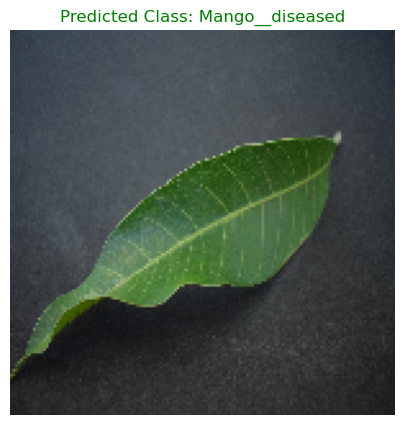

Predicted Class: Mango__diseased


In [20]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image_with_display(img_path, model, target_size=(150, 150)):
    """
    Predicts the class of an image and displays it.

    Parameters:
    - img_path (str): Path to the image to predict.
    - model (Keras model): Trained model used for prediction.
    - target_size (tuple): Size to which the image is resized.

    Outputs:
    - Predicted class and displays the input image.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    predicted_label = class_labels[predicted_class]

    # Display the image and prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Class: {predicted_label}", fontsize=12, color='green')
    plt.show()

    print(f"Predicted Class: {predicted_label}")

# Example Usage
predict_image_with_display(
    "/Users/reddysaireddyduggireddy/Downloads/archive/Testing Data/Mango__diseased/0012_0162.JPG", 
    model
)